# Gravitational wave detection with neural networks

In [Gabbard et al](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.120.141103) convolutional neural networks are used to detect simulated signals from binary black hole coalescence in noisy data. This notebook outlines the approached used with a snippet of the data used in the publication.

A convolutional neural network will used to detect the signals and its performance analysed.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mj-will/intro2ml/blob/master/notebooks/gravitational-wave-detection.ipynb)

In [0]:
import os
from six.moves import cPickle as pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style()

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam


## Data

Data is available [here](http://www.astro.gla.ac.uk/users/michael/datasets/bbh/BBH_training_1s_1024Hz_10Ksamp_1n_iSNR8_Hdet_astromass_1seed_ts_0.pkl) but this notebook will automatically download it with the following function.

The data consists of time series which will be labelled `x` and labels (no signal/signal) labelled `y`. The dimensions of the time series array will be:
`[number of time series, number of detectors, number of samples]`

The number of samples with depend on the duration and sampling rate, in this example the data is one second long and sampled at 1024Hz.


In [0]:
def fetch_data(url, filename):
    """Fetch data from a url and save it to given file"""
    import urllib
    urllib.request.urlretrieve(url, filename=filename)

In [0]:
# url of the data
data_url = 'http://www.astro.gla.ac.uk/users/michael/datasets/bbh/BBH_training_1s_1024Hz_10Ksamp_1n_iSNR8_Hdet_astromass_1seed_ts_0.pkl'
# path to save the data
data_file = './data.pkl'
# only download the data if the file doesn't already exist
if not os.path.isfile(data_file):
    fetch_data(data_url, data_file)

In [0]:
def load_data(data_file, start=512, length=1024):
    """Load the data and remove the first and last 0.5 seconds of padding"""
    # load the pickled data
    with open(data_file, 'rb') as f:
        x, y = pickle.load(f)
    # ts are 2048 long, so want middle 1024 samples
    x = x[:,:,start:(start+length)]
    print(f'x shape: {x.shape}, y shape: {y.shape}')
    return x, y

In [5]:
x, y = load_data(data_file)

x shape: (10000, 1, 1024), y shape: (10000,)


Once the data is loaded plot one of the time series.

As mentioned before the sampling rate `fs` is 1024Hz and the duration is 1 second.

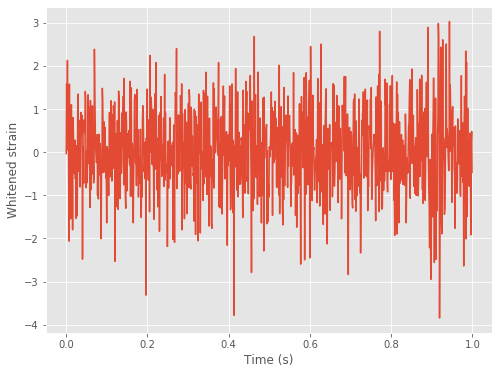

In [6]:
fs = 1024                           # sampling frequency
duration = 1
t = np.arange(0, duration, 1. / fs) # array of time steps
fig = plt.figure(figsize=(8,6))
plt.plot(t, x[0, 0])
plt.xlabel("Time (s)")
plt.ylabel("Whitened strain")
plt.show()

### Labels

In their original forms the labels are simply a list of zeros and ones with zero corresponding to no signal and one correponding to signal. We want the trained neural network to predict these labels as accurately as possible.


In [7]:
print(f'Label vector: {y[:10]}')

Label vector: [1 0 1 1 0 0 1 0 0 1]


Because of the loss function we're going to use this needs to be converted to a matrix form (also known as one-hot encoding).

Keras includes a function to do this automatically.

In [8]:
num_classes = 2
y_cat = keras.utils.to_categorical(y, num_classes)
print(f'Label matrices: {y_cat[:10]}')

Label matrices: [[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


Where the first column now corresponds to noise and the second to signal. So `[1. 0.]` indicates noise and `[0. 1.]` indicates a signal.

### Training/testing split

We reserve some of the data to use after training. This is used to test the network peformance on unseen data.

In this case we reserve 10% of the data.

In [0]:
n_train = int(0.9 * x.shape[0])
x_train, x_test = x[:n_train], x[n_train:]
y_train, y_test = y_cat[:n_train], y_cat[n_train:]

## The model

The model define the structure of the neural network we're going to train.

In this case we're going to use a mix of convolutional layers and fully connected layers.

In [0]:
batch_size = 50              # number of samples in each batch of training data
input_shape = [1, 1024]      # shape of the data
activation = 'relu'          # activation function

In [13]:
model = Sequential()
model.add(Conv1D(16, 
                 kernel_size=16, 
                 input_shape=input_shape, 
                 activation=activation,
                 data_format='channels_first'))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(16, 
                 kernel_size=16, 
                 activation=activation,
                 data_format='channels_first'))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(32, activation=activation))
model.add(Dense(2, activation='softmax'))
print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16, 1009)          272       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4, 1009)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 994)           1040      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 994)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3976)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                127264    
_________________________________________

### Compiling

In keras the model must be compiled before training. It's at this stage that we specify the loss function to use and what optimiser to use.

The optimiser is the algorithm that is used to explore the parameter space of the network weights.

In this case we're using Categorical Crossentropy as the loss function. This combined with the Softmax layer means the network will ouput a vector of probabilities for each samples where each probability corresponds to a particular class.
For this binary (noise/signal) case it can written as:

$$f(\theta) = - \sum_{i \in S} log(\theta_{i}^{S}) - \sum_{i \in N} log(\theta_{i}^{N})$$

where $\theta_{i}^{S/N}$ is the predicted probability of class signal-noise (S) or noise-only (N).

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001), metrics=['accuracy'])

## Training

When training the network we train for a set number of complete passes of the data known as epochs.

A portion of the data (the validation set) is used to keep track of the networks performance during training. Importantly it is never used to update the networks parameters.

In [15]:
n_epochs = 10
history = model.fit(x_train, y_train, validation_split=0.2, batch_size=batch_size, epochs=n_epochs)

Train on 7200 samples, validate on 1800 samples
Epoch 1/10
7200/7200 [==============================] - 2s 296us/sample - loss: 0.6414 - acc: 0.6187 - val_loss: 0.4692 - val_acc: 0.7889
Epoch 2/10
7200/7200 [==============================] - 1s 94us/sample - loss: 0.4396 - acc: 0.7967 - val_loss: 0.3697 - val_acc: 0.8433
Epoch 3/10
7200/7200 [==============================] - 1s 93us/sample - loss: 0.3265 - acc: 0.8618 - val_loss: 0.2322 - val_acc: 0.9083
Epoch 4/10
7200/7200 [==============================] - 1s 92us/sample - loss: 0.2175 - acc: 0.9118 - val_loss: 0.1864 - val_acc: 0.9256
Epoch 5/10
7200/7200 [==============================] - 1s 94us/sample - loss: 0.1814 - acc: 0.9281 - val_loss: 0.1793 - val_acc: 0.9239
Epoch 6/10
7200/7200 [==============================] - 1s 98us/sample - loss: 0.1629 - acc: 0.9347 - val_loss: 0.1695 - val_acc: 0.9328
Epoch 7/10
7200/7200 [==============================] - 1s 93us/sample - loss: 0.1613 - acc: 0.9342 - val_loss: 0.1777 - val_acc:

### Loss

We can plot the loss function to better understand how the network has trained

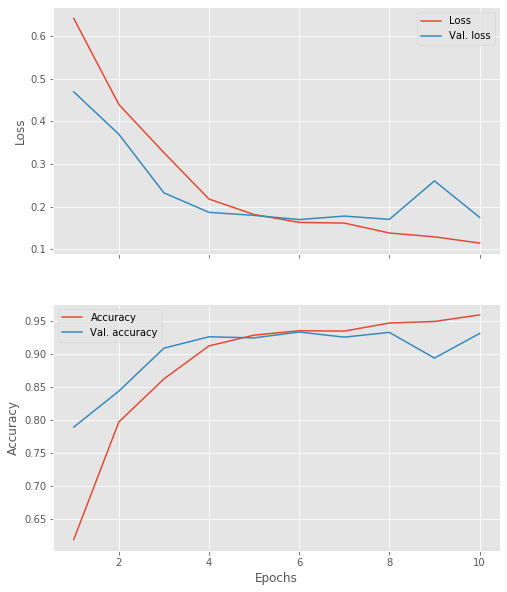

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
axs = axs.ravel()
epochs = np.arange(1, n_epochs+1)
axs[0].plot(epochs, history.history['loss'], label='Loss')
axs[0].plot(epochs, history.history['val_loss'], label='Val. loss')
axs[1].plot(epochs, history.history['acc'], label='Accuracy')
axs[1].plot(epochs, history.history['val_acc'], label='Val. accuracy')
# labels
axs[1].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[1].set_ylabel("Accuracy")
axs[0].legend()
axs[1].legend()
plt.show()

## Testing

Now the network is trained we can use the test set to further evaluate it's performance.

In [0]:
from sklearn import metrics

In [0]:
y_pred = model.predict(x_test)

In [0]:
fa, ta, _ = metrics.roc_curve(y_test[:,1], y_pred[:,1])

In [0]:
fig = plt.figure(figsize=(8,8))
plt.plot(fa, ta,)
plt.xlabel('False alarm probability')
plt.ylabel('True alarm probability')
plt.title('ROC curve ')
plt.show()